# ■ 日本腎・血液浄化AI学会主催「よくわかる寺子屋セミナー」

# 第5回「深層学習による画像問題」　演習プログラム

## □ 文責　学術委員会副委員長　岩藤和広

# 0. 環境設定

- MyDriveの中にTelakoya というフォルダーを作成し、その中に tela5 というフォルダーを作成する
- フォルダー tela4 の中に model というフォルダーを作る。

- 最初に、このnotebookをGoogle Driveにmount(Google driveに接続)する。
- その方法は、https://github.com/kiwindow/telakoya の中の「Google Colabortoryの使い方」を参照。
- 【重要】 mountする前に
- 「ランタイム」➡「ランタイムのタイプを変更」➡「ハードウェアアクセラレータ」を「GPU」に切り替えて保存する。
- 　これを行わないと、エラーが出たり、計算に長い時間がかかる。
- mount出来ると、左のサイドバーに drive というフォルダーが現れる。
- もし drive というフォルダーがなければ、次のセルを実行する。

In [ ]:
# Gogle driveにmountする
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 以下のコマンドでどの種類のGPUに接続したかが分かる
!nvidia-smi

Mon May 15 01:02:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    46W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. ライブラリやデータの準備

## 1) ライブラリの読み込み

- Tensorflow2のwrapperであるKerasを利用する。
- 深層学習はTensorflow2かPyTorchというframeworkを利用するが、どちらもプログラムがやや煩雑。
- KerasはTensorflow2を機械学習のsklearnのような書式で書けるようにしたもの。
- Tensorflow2は企業などで、PyTorchは研究機関などで、それぞれ利用されることが多い。

In [ ]:
# ライブラリの読み込み
import tensorflow as tf
from tensorflow import keras
# from keras import datasets, layers, models

import numpy as np  # 数値計算のライブラリ
import matplotlib.pyplot as plt  # 図示のライブラリ
%matplotlib inline

## 2) データの読み込み

- mnist と呼ばれる手書き数字(0〜9)の画像データを利用する。
- mnist には、学習データが60,000字、検証データが10,000字ある。
- データは、28×28個の整数(0〜255)からなる行列で形成されている。
- 一つ一つの文字には、0〜9の正解データも付いている。

In [ ]:
# データの読み込み
from keras.datasets import mnist
(x_train, t_train), (x_test, t_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# データ数の確認
len(x_train)

60000

In [ ]:
len(x_test)

10000

In [ ]:
# データの形の確認
x_train.shape

(60000, 28, 28)

In [ ]:
x_test.shape

(10000, 28, 28)

In [ ]:
# データの中身の確認
x_train[0]

In [ ]:
t_train[0]

5

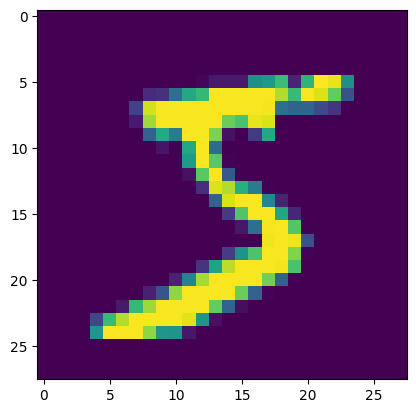

In [ ]:
# データの図示
plt.imshow(x_train[0])

## 3) 画像データの正規化・浮動小数点化とChannelの次元の付加

- 整数のデータを、0〜1の浮動小数点(float32)に正規化する。
- 個々のデータの形を、(縦の数、横の数、Channel)にする。

In [ ]:
# 画像データの正規化(0〜1)と小数化(float32)
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [ ]:
# 正規化とfloat32になったことの確認
x_train[0]

https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html

In [ ]:
# 個々のデータの形を 28 x 28 x 1 とする (channelの次元を最後に加える)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [ ]:
# データの形の確認
x_train.shape

(60000, 28, 28, 1)

In [ ]:
x_train[0].shape

(28, 28, 1)

## 4) 正解データをOne Hot vectorにする

https://keras.io/ja/utils/#to_categorical

In [ ]:
from keras.utils import to_categorical
t_train = to_categorical(t_train, 10)
t_test = to_categorical(t_test, 10)

In [ ]:
# One Hot vectorになったことの確認
t_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

# 2. 三層のPerceptronによる画像分類

## 1) モデルの設計

https://www.tensorflow.org/guide/keras/sequential_model?hl=ja

In [ ]:
# Neural Networkを形成するモジュールの読み込み
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout

In [ ]:
# 三層のPerceptronの作製。中間層の活性化関数はRelu、出力層の活性化関数はsoftmaxとする。
model = Sequential([
    Flatten(input_shape=(28,28,1)),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

In [ ]:
# モデルの構成の確認
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


## 2) モデルの学習

https://www.tensorflow.org/guide/keras/train_and_evaluate?hl=ja

- 損失関数が Categorical Crossentropyの場合、正解データはOne Hot vectorにする必要がある。

In [ ]:
# 人間が読み書きする source code を、機会が読み書きする machine code にコンパイルする。
# その際、1) 最適化アルゴリズム、2) 損失関数、3) 評価指標なども設定する。
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# モデルの学習を実行する。trainとかfitと呼ばれるmethodで実行する。
# その際、1) training data : validation dataの比　2) バッチサイズ 3) エポック数も設定する。
history = model.fit(x_train, t_train, validation_split = 0.2, batch_size = 128, epochs = 10)

Epoch 1/10
375/375 [==============================] - 7s 4ms/step - loss: 0.3307 - accuracy: 0.9055 - val_loss: 0.1550 - val_accuracy: 0.9548
Epoch 2/10
375/375 [==============================] - 1s 3ms/step - loss: 0.1452 - accuracy: 0.9573 - val_loss: 0.1130 - val_accuracy: 0.9676
Epoch 3/10
375/375 [==============================] - 1s 3ms/step - loss: 0.1040 - accuracy: 0.9694 - val_loss: 0.0959 - val_accuracy: 0.9705
Epoch 4/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0801 - accuracy: 0.9757 - val_loss: 0.0846 - val_accuracy: 0.9745
Epoch 5/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0632 - accuracy: 0.9810 - val_loss: 0.0848 - val_accuracy: 0.9743
Epoch 6/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0525 - accuracy: 0.9840 - val_loss: 0.0790 - val_accuracy: 0.9757
Epoch 7/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0450 - accuracy: 0.9867 - val_loss: 0.0702 - val_accuracy: 0.9783
Epoch 

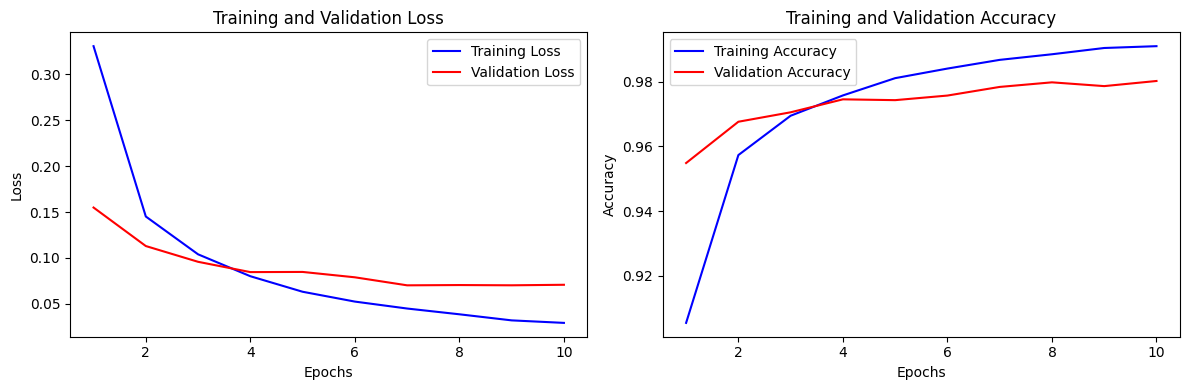

In [ ]:
# 学習過程の図示

# Access the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot of the training and validation loss
epochs = np.arange(1, len(train_loss) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot　of the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 3) モデルの検証

https://www.tensorflow.org/guide/keras/train_and_evaluate?hl=ja

In [ ]:
score = model.evaluate(x_test, t_test, verbose = 0)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

Test loss:  0.06209327280521393
Test accuracy:  0.982200026512146


## 4) モデルの保存と復元

https://www.tensorflow.org/guide/keras/save_and_serialize?hl=ja

In [ ]:
# モデルの保存。HDF5ファイルで保存される。
model.save('/content/drive/MyDrive/Telakoya/tela5/model/perceptron.h5')

In [ ]:
# モデルの復元。
from keras.models import load_model
model2 = load_model('/content/drive/MyDrive/Telakoya/tela5/model/perceptron.h5')

In [ ]:
# 保存前のモデルによる予測結果
pred = model.predict(x_test[0:1])
pred

1/1 [==============================] - 0s 22ms/step


array([[2.9993055e-09, 8.3699531e-10, 4.2550078e-06, 1.3529074e-04,
        2.9455334e-12, 2.1283764e-09, 1.4824101e-12, 9.9985933e-01,
        1.3780112e-07, 9.1623264e-07]], dtype=float32)

In [ ]:
# 復元したモデルによる予測結果
pred2 = model2.predict(x_test[0:1])
pred2

1/1 [==============================] - 0s 22ms/step


array([[2.9993055e-09, 8.3699531e-10, 4.2550078e-06, 1.3529074e-04,
        2.9455334e-12, 2.1283764e-09, 1.4824101e-12, 9.9985933e-01,
        1.3780112e-07, 9.1623264e-07]], dtype=float32)

## 補題 Fashion mnistによる画像分類

https://www.tensorflow.org/tutorials/keras/classification?hl=ja

- Fashion mnistというデータセットがあり、mnistと同じ構造で作られている。
- これまでおこなってきたPerceptronによるモデルで、Fashion mnistも分類できる。
- 以下のように、読み込むデータを入れ替えるだけでよい


In [ ]:
# Fashion mnistの読み込み
from keras.datasets import fashion_mnist
(x_train, t_train), (x_test, t_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
# Fashion mnistのデータの前処理

# データの正規化 (0〜1)
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

# データの形を 28 x 28 x 1 にする (channelを加える)
import numpy as np
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# 正解データをone hot vectorにする
t_train = keras.utils.to_categorical(t_train, 10)
t_test = keras.utils.to_categorical(t_test, 10)

# 10種類の画像
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

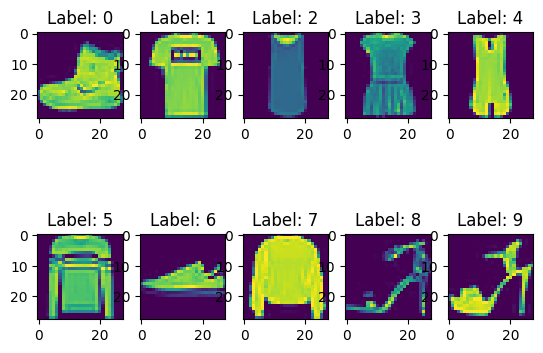

In [ ]:
# 最初の10個の画像の図示
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.title('Label: ' + str(i))
    plt.imshow(x_train[i])

# 3. CNNによる画像分類

https://www.tensorflow.org/tutorials/images/cnn?hl=ja

## 1) ライブラリの読み込み

- Tensorflow2のwrapperであるKerasを利用する。


In [ ]:
# ライブラリの読み込み
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import numpy as np  # 数値計算のライブラリ
import matplotlib.pyplot as plt  # 図示のライブラリ
%matplotlib inline

## 2) データの読み込み

- CIFAR10 と呼ばれるカラー画像データを利用する。
- CIFAR10 には、学習データが60,000字、検証データが10,000字ある。
- データは、32×32個の整数(0〜255)が3組ある行列(テンソル)で形成されている。
- 一つ一つの文字には、0〜9の正解データも付いている。

In [ ]:
# データの読み込み
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [ ]:
# データ数の確認
len(train_images)

50000

In [ ]:
len(test_images)

10000

In [ ]:
# データの形の確認
train_images.shape

(50000, 32, 32, 3)

In [ ]:
test_images.shape

(10000, 32, 32, 3)

In [ ]:
# データの中身の確認
train_images[0]

- モデルの損失関数がSparse Categorical Crossentropyの場合、正解データは一次元でよい。

In [ ]:
train_labels[0]

array([6], dtype=uint8)

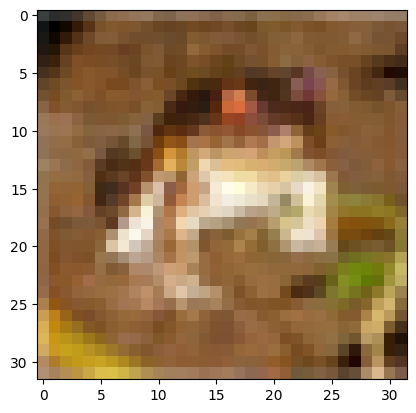

In [ ]:
# データの図示
plt.imshow(train_images[0])

In [ ]:
# 最初の25個の画像の図示
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## 3) モデルの設計

In [ ]:
# CNN (Convolutional Neural Network)の構造。最初に空のSequentialをインスタンス化し、それにLayerを加えてゆく形を取っている。
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

# モデルのアーキテクチャ(構造)の表示
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
 flatten_8 (Flatten)         (None, 1024)             

## 4) モデルの学習

In [ ]:
# モデルのコンパイル
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# モデルの学習
history = model.fit(train_images, train_labels, epochs=10, validation_split = 0.2)

Epoch 1/10
1250/1250 [==============================] - 7s 5ms/step - loss: 1.9689 - accuracy: 0.3258 - val_loss: 1.5845 - val_accuracy: 0.4262
Epoch 2/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.4272 - accuracy: 0.4884 - val_loss: 1.4114 - val_accuracy: 0.4989
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.2678 - accuracy: 0.5504 - val_loss: 1.2541 - val_accuracy: 0.5587
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.1487 - accuracy: 0.5974 - val_loss: 1.1486 - val_accuracy: 0.6016
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.0564 - accuracy: 0.6320 - val_loss: 1.1653 - val_accuracy: 0.5989
Epoch 6/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.9760 - accuracy: 0.6598 - val_loss: 1.1465 - val_accuracy: 0.6191
Epoch 7/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.9035 - accuracy: 0.6853 - val_loss: 1.0935 - val_accuracy:

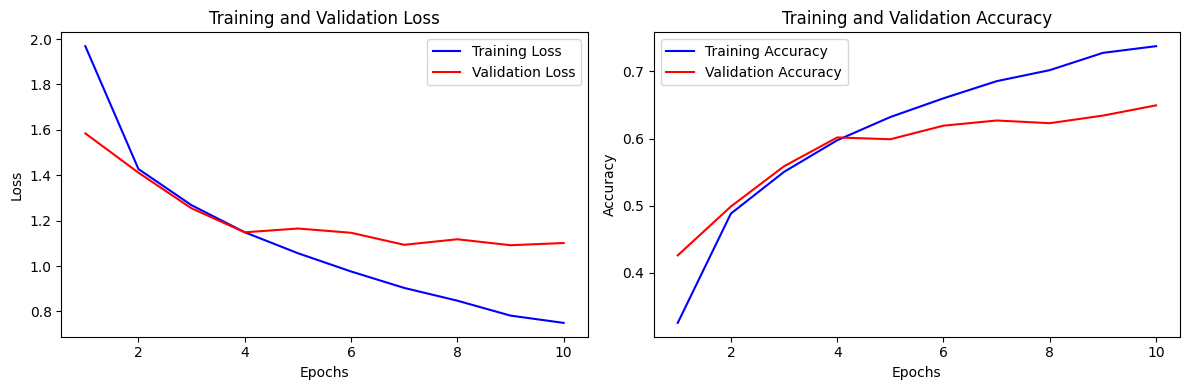

In [ ]:
# 学習過程の図示

# Access the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot of the training and validation loss
epochs = np.arange(1, len(train_loss) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot　of the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 5) モデルの検証

In [ ]:
score = model.evaluate(test_images, test_labels, verbose = 0)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

Test loss:  1.0975841283798218
Test accuracy:  0.652999997138977


## 6) モデルの保存と復元

In [ ]:
# モデルの保存。HDF5ファイルで保存される。
model.save('/content/drive/MyDrive/Telakoya/tela5/model/cnn.h5')

In [ ]:
# モデルの復元。
from keras.models import load_model
model2 = load_model('/content/drive/MyDrive/Telakoya/tela5/model/cnn.h5')

In [ ]:
# 保存前のモデルによる予測結果
pred = model.predict(test_images[0:1])
pred

1/1 [==============================] - 0s 150ms/step


array([[ 2.115134  ,  0.84171724,  3.6655068 ,  6.607142  ,  1.9444997 ,
         4.6826024 ,  2.5249922 ,  0.9799721 ,  4.4108725 , -0.58072466]],
      dtype=float32)

In [ ]:
# 復元したモデルによる予測結果
pred2 = model2.predict(test_images[0:1])
pred2

1/1 [==============================] - 0s 75ms/step


array([[ 2.115134  ,  0.84171724,  3.6655068 ,  6.607142  ,  1.9444997 ,
         4.6826024 ,  2.5249922 ,  0.9799721 ,  4.4108725 , -0.58072466]],
      dtype=float32)

# 4. ChatGPTが提案したモデルによる分類

## 1) ライブラリの読み込み

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

## 2) データの読み込み

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

## 3) モデルの設計

- 【ChatGPTに入力したprompt】
- I want to make a CNNN model using keras to classifiy cifar10 dataset with a high accuracy. Please sugget such a model.

In [ ]:
# ChatGPTが提案したモデル

import tensorflow as tf
from tensorflow.keras import layers

# Define the model
model = tf.keras.Sequential()

# Convolutional layer 1
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

# Convolutional layer 2
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

# Convolutional layer 3
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

# Flatten the output
model.add(layers.Flatten())

# Fully connected layers
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                      

## 4) モデルの学習

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=25, validation_split = 0.2)

Epoch 1/25
1250/1250 [==============================] - 18s 10ms/step - loss: 1.6223 - accuracy: 0.4589 - val_loss: 1.2142 - val_accuracy: 0.5868
Epoch 2/25
1250/1250 [==============================] - 11s 9ms/step - loss: 1.0406 - accuracy: 0.6334 - val_loss: 0.9479 - val_accuracy: 0.6714
Epoch 3/25
1250/1250 [==============================] - 11s 9ms/step - loss: 0.8851 - accuracy: 0.6902 - val_loss: 0.9850 - val_accuracy: 0.6528
Epoch 4/25
1250/1250 [==============================] - 12s 9ms/step - loss: 0.7971 - accuracy: 0.7210 - val_loss: 0.8120 - val_accuracy: 0.7264
Epoch 5/25
1250/1250 [==============================] - 11s 9ms/step - loss: 0.7326 - accuracy: 0.7469 - val_loss: 0.7121 - val_accuracy: 0.7607
Epoch 6/25
1250/1250 [==============================] - 11s 9ms/step - loss: 0.6610 - accuracy: 0.7705 - val_loss: 0.6253 - val_accuracy: 0.7870
Epoch 7/25
1250/1250 [==============================] - 11s 9ms/step - loss: 0.6134 - accuracy: 0.7879 - val_loss: 0.5820 - val_a

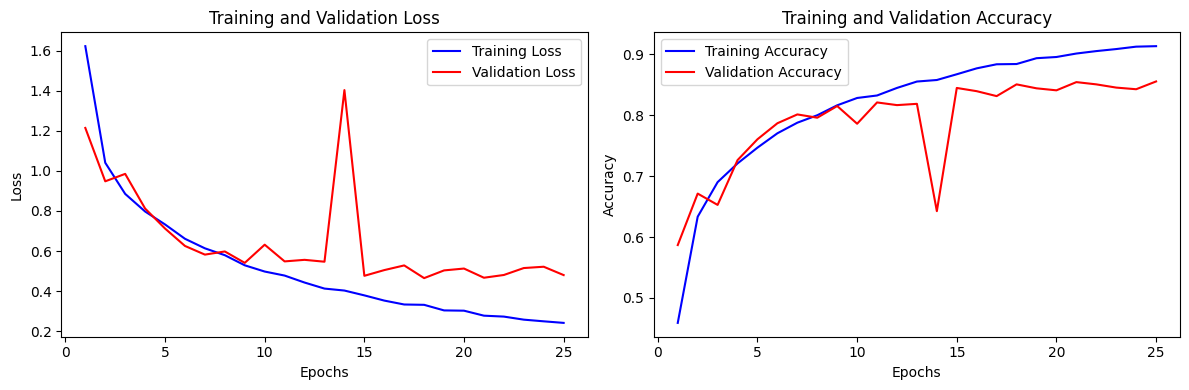

In [ ]:
# モデルの学習過程

# Access the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot of the training and validation loss
epochs = np.arange(1, len(train_loss) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot　of the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 5) モデルの検証

In [ ]:
score = model.evaluate(test_images, test_labels, verbose = 0)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

Test loss:  0.5196828842163086
Test accuracy:  0.8432999849319458


- 検証データで、Accuracy 84.3%。

- ChatGPTは、更なる予測精度の向上のため、以下のような suggestion も提案した。
- 1. Data Augmentation データの水増し (反転、回転、移動など)
- 2. より高度な ResNet, DenseNet, EfficientNet などの利用。
- 3. Hyperparameterのチューニング
- 4. 正則化 (regularization) L1, L2などで、次元削減を行う

## 6) モデルの保存と復元

In [ ]:
# モデルの保存。HDF5ファイルで保存される。
model.save('/content/drive/MyDrive/Telakoya/tela5/model/cnnC.h5')

In [ ]:
# モデルの復元。
from keras.models import load_model
model2 = load_model('/content/drive/MyDrive/Telakoya/tela5/model/cnnC.h5')

In [ ]:
# 保存前のモデルによる予測結果
pred = model.predict(test_images[0:1])
pred

1/1 [==============================] - 0s 370ms/step


array([[9.3048686e-05, 1.6300348e-06, 1.9930166e-04, 9.9537200e-01,
        9.0210541e-09, 4.1212486e-03, 1.9730124e-04, 4.6229837e-07,
        1.1862066e-05, 3.0614469e-06]], dtype=float32)

In [ ]:
# 復元したモデルによる予測結果
pred2 = model2.predict(test_images[0:1])
pred2

1/1 [==============================] - 0s 173ms/step


array([[9.3048686e-05, 1.6300348e-06, 1.9930166e-04, 9.9537200e-01,
        9.0210541e-09, 4.1212486e-03, 1.9730124e-04, 4.6229837e-07,
        1.1862066e-05, 3.0614469e-06]], dtype=float32)

# 5. Kaggleで提案されたモデルによる分類

- 世界的な機械学習のCompetitionであるKaggleにおいて、Cifar10の画像分類で銀メダリストが提案したモデル。

https://www.kaggle.com/code/kedarsai/cifar-10-88-accuracy-using-keras

## 1) ライブラリの読み込み

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from keras.layers import BatchNormalization, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

## 2) データの読み込み

- モデルの損失関数が Cross Entropy のため、正解データは One Hot vectorに変換する

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

from keras.utils import to_categorical
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

## 3) モデルの設計

In [ ]:
model6 = models.Sequential()
model6.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model6.add(BatchNormalization())
model6.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model6.add(BatchNormalization())
model6.add(MaxPool2D((2, 2)))
model6.add(layers.Dropout(0.2))
model6.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model6.add(BatchNormalization())
model6.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model6.add(BatchNormalization())
model6.add(MaxPool2D((2, 2)))
model6.add(layers.Dropout(0.3))
model6.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model6.add(BatchNormalization())
model6.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model6.add(BatchNormalization())
model6.add(MaxPool2D((2, 2)))
model6.add(layers.Dropout(0.4))
model6.add(layers.Flatten())
model6.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
model6.add(BatchNormalization())
model6.add(layers.Dropout(0.5))
model6.add(layers.Dense(10, activation='softmax'))

model6.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_14 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_37 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_15 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                     

## 4) モデルの学習

In [ ]:
# compile model
# opt = SGD(lr=0.001, momentum=0.9)
model6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Image Data Generator , we are shifting image accross width and height also we are flipping the image horizantally.
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True,rotation_range=20)
it_train = datagen.flow(train_images, train_labels)
steps = int(train_images.shape[0] / 64)

# Be patient. It will take some time to train the due to 200 epochs of optimization.
history6=model6.fit_generator(it_train, epochs=200, steps_per_epoch=steps, validation_data=(test_images, test_labels))

Epoch 1/200


<ipython-input-113-b4162ae07747>:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history6=model6.fit_generator(it_train, epochs=200, steps_per_epoch=steps, validation_data=(test_images, test_labels))


781/781 [==============================] - 21s 20ms/step - loss: 1.9806 - accuracy: 0.3344 - val_loss: 1.3675 - val_accuracy: 0.5014
Epoch 2/200
781/781 [==============================] - 15s 20ms/step - loss: 1.4664 - accuracy: 0.4719 - val_loss: 1.4320 - val_accuracy: 0.5120
Epoch 3/200
781/781 [==============================] - 15s 19ms/step - loss: 1.3018 - accuracy: 0.5330 - val_loss: 1.2757 - val_accuracy: 0.5483
Epoch 4/200
781/781 [==============================] - 15s 19ms/step - loss: 1.1855 - accuracy: 0.5812 - val_loss: 1.0316 - val_accuracy: 0.6297
Epoch 5/200
781/781 [==============================] - 15s 20ms/step - loss: 1.0941 - accuracy: 0.6182 - val_loss: 0.9296 - val_accuracy: 0.6828
Epoch 6/200
781/781 [==============================] - 15s 20ms/step - loss: 1.0358 - accuracy: 0.6387 - val_loss: 0.8136 - val_accuracy: 0.7133
Epoch 7/200
781/781 [==============================] - 15s 19ms/step - loss: 0.9881 - accuracy: 0.6555 - val_loss: 1.2702 - val_accuracy: 0.58

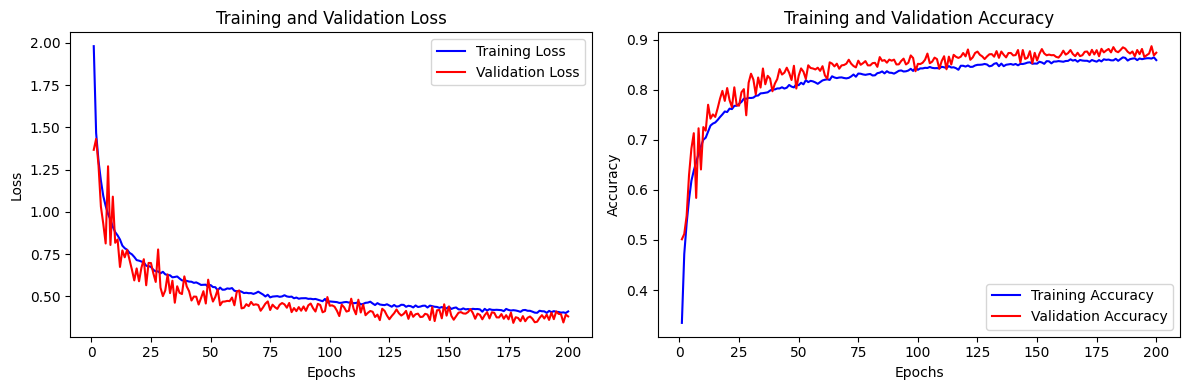

In [ ]:
# モデルの学習過程

# Access the training history
train_loss = history6.history['loss']
val_loss = history6.history['val_loss']
train_accuracy = history6.history['accuracy']
val_accuracy = history6.history['val_accuracy']

# Plot of the training and validation loss
epochs = np.arange(1, len(train_loss) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot　of the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 5) モデルの検証

In [ ]:
score = model6.evaluate(test_images, test_labels, verbose = 0)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

Test loss:  0.38208404183387756
Test accuracy:  0.8740000128746033


- 検証データで、Accuracy 87.4% を達成した。

## 6) モデルの保存と復元

In [ ]:
# モデルの保存。HDF5ファイルで保存される。
model6.save('/content/drive/MyDrive/Telakoya/tela5/model/cnnK.h5')

In [ ]:
# モデルの復元。
from keras.models import load_model
model62 = load_model('/content/drive/MyDrive/Telakoya/tela5/model/cnnK.h5')

In [ ]:
# 保存前のモデルによる予測結果
pred = model6.predict(test_images[0:1])
pred

1/1 [==============================] - 0s 171ms/step


array([[7.1535003e-04, 1.4320160e-03, 1.0530756e-02, 8.1961149e-01,
        6.8566151e-04, 9.9383844e-03, 1.4954913e-01, 9.1346759e-05,
        5.9183552e-03, 1.5274881e-03]], dtype=float32)

In [ ]:
# 復元したモデルによる予測結果
pred2 = model62.predict(test_images[0:1])
pred2

1/1 [==============================] - 0s 171ms/step


array([[7.1535003e-04, 1.4320160e-03, 1.0530756e-02, 8.1961149e-01,
        6.8566151e-04, 9.9383844e-03, 1.4954913e-01, 9.1346759e-05,
        5.9183552e-03, 1.5274881e-03]], dtype=float32)